In [41]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from abnormals import abnormal_samples_21

In [42]:
target_size = 21
target_cultivar = 'RIES'


round_numbers = [2, 3, 4]
 # npy data path -> {'label': 0/1, 'cultivar': 'cultivar_name'}
total_video_map = {}



for round_number in round_numbers:
    roi_data_folder = f'C:/Users/Mud/Desktop/2ndPaper/roi_data/round_{round_number}/'
    data_status_csv = f'C:/Users/Mud/Desktop/2ndPaper/roi_data/csv/stat_all_data_extend_mean_normalization_pca_round_{round_number}.csv'

   
    # Load the data status
    data_status = pd.read_csv(data_status_csv)
    data_status_this_round = data_status[data_status['dev_stage'] == round_number]


    # Load the data and append without flattening
    for index, row in data_status_this_round.iterrows():
        filename = row['filename']
        cultivar = row['cultivar']
        mortality = row['mortality']
        treatment = row['treatment']
        npy_data_path = f'{roi_data_folder}[ROI]{filename}'
        video_data = np.load(npy_data_path)

        if cultivar == target_cultivar:

            if 1 <= treatment < 5:
                if mortality:
                    total_video_map[npy_data_path] = {'label': 1, 'cultivar': cultivar}
                else:
                    total_video_map[npy_data_path] = {'label': 0, 'cultivar': cultivar}
                print(f'Loaded {filename} with shape {video_data.shape}')

Loaded Ries_2.0_B01_N01.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N02.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N03.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N04.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N05.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N06.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N07.npy with shape (600, 21, 21)
Loaded Ries_2.0_B01_N09.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N01.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N02.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N03.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N04.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N05.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N06.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N07.npy with shape (600, 21, 21)
Loaded Ries_2.0_B02_N08.npy with shape (600, 21, 21)
Loaded Ries_2.0_B03_N01.npy with shape (600, 21, 21)
Loaded Ries_2.0_B03_N02.npy with shape (600, 21, 21)
Loaded Ries_2.0_B03_N03.npy with shape (600, 2

In [43]:
def stratified_balanced_test_split(X, y, test_size_per_class=60, random_state=None):
    # Ensure input types are consistent
    X = X.copy()
    y = y.copy()

    # Separate by class
    classes = y.unique()
    if len(classes) != 2:
        raise ValueError("This function currently supports only binary classification.")

    class0, class1 = classes[0], classes[1]
    X0, y0 = X[y == class0], y[y == class0]
    X1, y1 = X[y == class1], y[y == class1]

    if len(y0) < test_size_per_class or len(y1) < test_size_per_class:
        raise ValueError(f"Not enough samples to extract {test_size_per_class} from each class.")

    # Split each class for test set (fixed size)
    X0_train, X0_test, y0_train, y0_test = train_test_split(
        X0, y0, test_size=test_size_per_class, random_state=random_state, stratify=None
    )
    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, y1, test_size=test_size_per_class, random_state=random_state, stratify=None
    )

    # Combine test sets and shuffle
    X_test = pd.concat([X0_test, X1_test]).sample(frac=1, random_state=random_state)
    y_test = pd.concat([y0_test, y1_test]).loc[X_test.index]

    # Combine training sets
    X_train = pd.concat([X0_train, X1_train])
    y_train = pd.concat([y0_train, y1_train]).loc[X_train.index]

    return X_train, X_test, y_train, y_test

In [44]:
# cultivar-specific data
# split the train set into train and validation sets, 80% train, 20% validation
video_paths = list(total_video_map.keys())
labels = [total_video_map[path]['label'] for path in video_paths]
X = pd.DataFrame(index=video_paths)  # empty DataFrame with video paths as index
y = pd.Series(labels, index=video_paths)
X_train, X_test, y_train, y_test = stratified_balanced_test_split(X, y, test_size_per_class=70, random_state=42)
train_videos, valid_videos, train_labels, valid_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
test_videos, test_labels = X_test, y_test

print('Train:', train_videos.shape, train_labels.shape)
print('Valid:', valid_videos.shape, valid_labels.shape)
print('Test:', test_videos.shape, test_labels.shape)

Train: (737, 0) (737,)
Valid: (185, 0) (185,)
Test: (140, 0) (140,)


In [45]:
# split the train set into train and validation sets, 80% train, 20% validation
train_videos, valid_videos, train_labels, valid_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
test_videos, test_labels = X_test, y_test

print('Train:', train_videos.shape, train_labels.shape)
print('Valid:', valid_videos.shape, valid_labels.shape)
print('Test:', test_videos.shape, test_labels.shape)


train_video_to_label_map = train_labels.to_dict()
val_video_to_label_map = valid_labels.to_dict()
test_video_to_label_map = test_labels.to_dict()

Train: (737, 0) (737,)
Valid: (185, 0) (185,)
Test: (140, 0) (140,)


In [46]:
%matplotlib widget

def normalize_curve_mean_method1(input_data):
    mean = np.mean(input_data[:30])
    normalized_data = np.maximum(input_data - mean, 0)
    return normalized_data

def visualizer(label_map, start_idx=0, end_idx=20):
    video_paths = list(label_map.keys())
    total_samples = len(video_paths)

    # Validate indices
    start_idx = max(0, start_idx)
    end_idx = min(end_idx, total_samples)
    sampled_paths = video_paths[start_idx:end_idx]

    plt.figure(figsize=(10, 5))
    lines = []
    for video_path in sampled_paths:
        video_array = np.load(video_path)
        video_curve = np.mean(video_array, axis=(1, 2))
        video_curve = normalize_curve_mean_method1(video_curve)
        label = label_map[video_path]
        line, = plt.plot(
            video_curve,
            color={0: 'blue', 1: 'red'}.get(label, 'gray'),
            alpha=0.5
        )
        line._video_path = video_path  # Attach metadata
        lines.append(line)

    plt.xlabel('Frame')
    plt.ylabel('Mean Value')
    plt.title(f'Time-Series Curves [{start_idx}:{end_idx}]')

    # Add hover annotations
    cursor = mplcursors.cursor(lines, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set(text=os.path.basename(sel.artist._video_path))

    plt.tight_layout()
    plt.show()

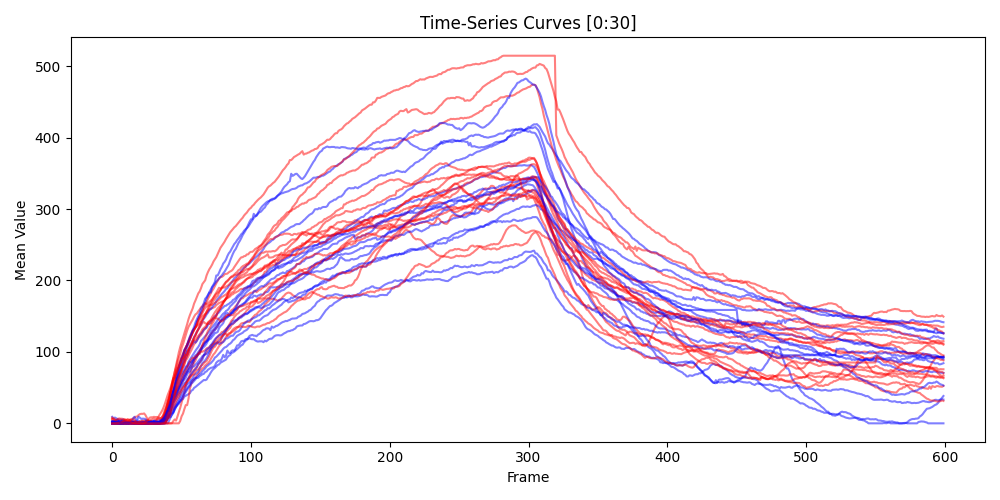

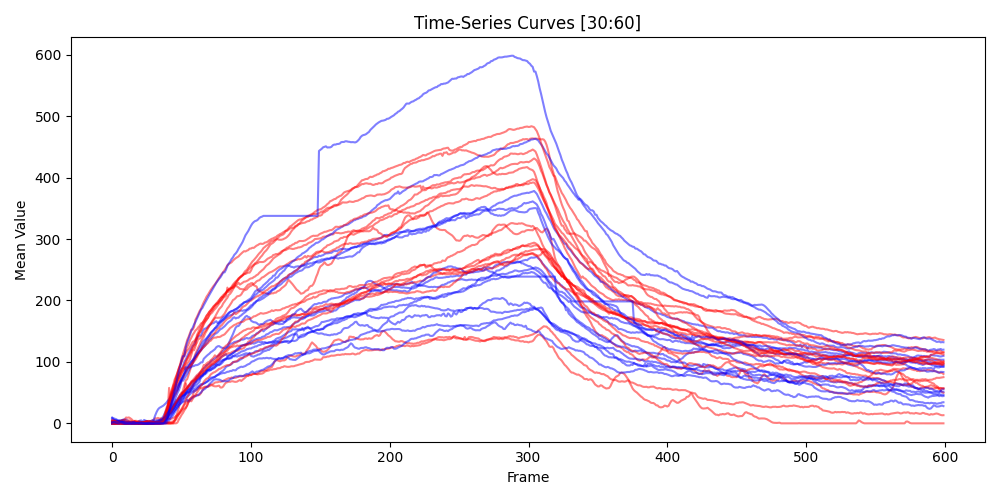

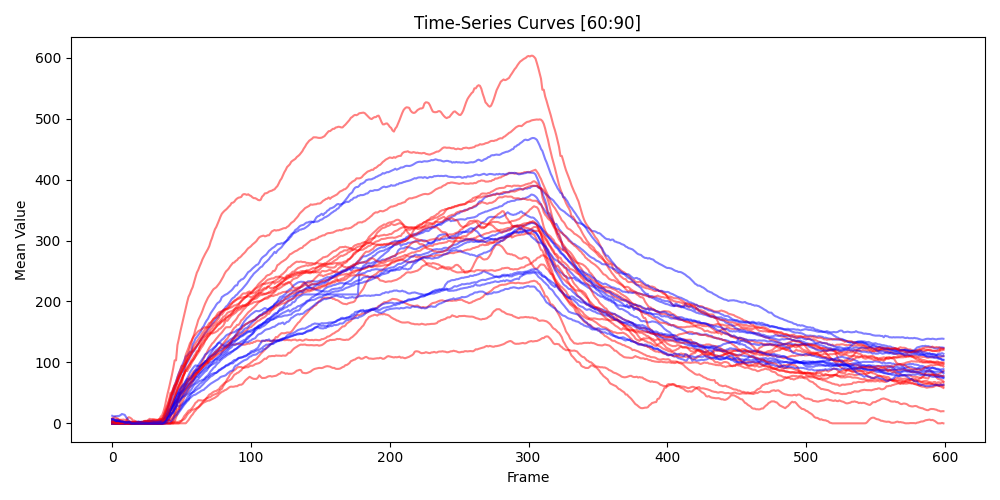

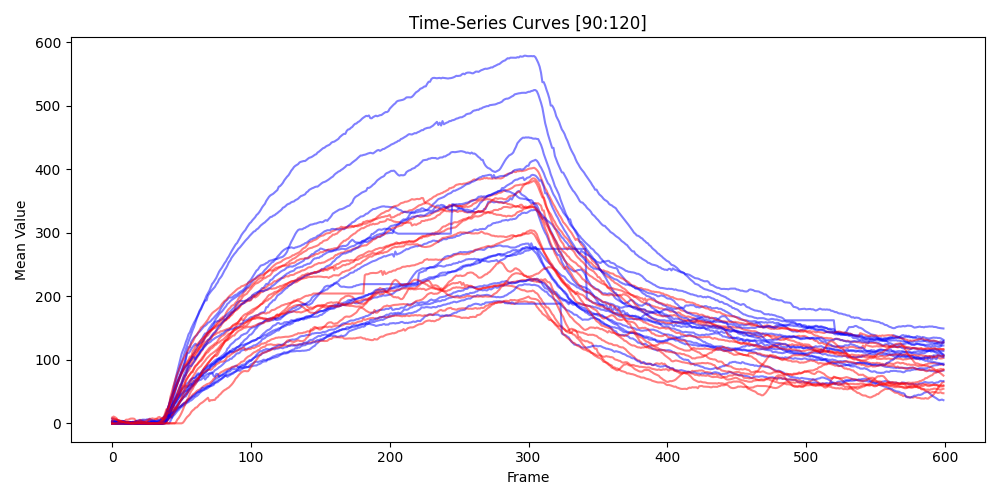

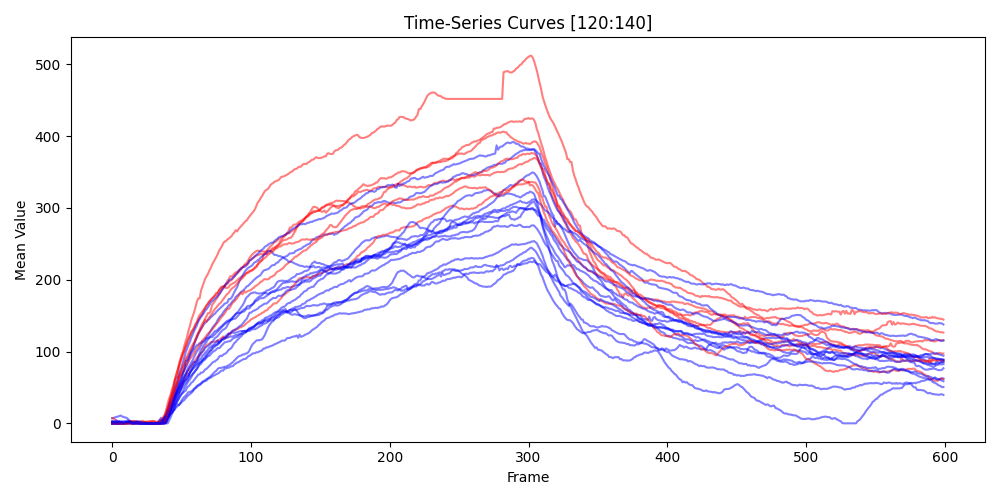

In [50]:
# visualizer(train_video_to_label_map, 0, 30)
# visualizer(train_video_to_label_map, 30, 60)
# visualizer(train_video_to_label_map, 60, 90)
# visualizer(train_video_to_label_map, 90, 120)
# visualizer(train_video_to_label_map, 120, 150)
# visualizer(train_video_to_label_map, 150, 180)
# visualizer(train_video_to_label_map, 180, 210)
# visualizer(train_video_to_label_map, 210, 240)
# visualizer(train_video_to_label_map, 240, 270)
# visualizer(train_video_to_label_map, 270, 300)
# visualizer(train_video_to_label_map, 300, 330)
# visualizer(train_video_to_label_map, 330, 360)
# visualizer(train_video_to_label_map, 360, 390)
# visualizer(train_video_to_label_map, 390, 420)
# visualizer(train_video_to_label_map, 420, 450)
# visualizer(train_video_to_label_map, 450, 480)
# visualizer(train_video_to_label_map, 480, 510)
# visualizer(train_video_to_label_map, 510, 540)
# visualizer(train_video_to_label_map, 540, 570)
# visualizer(train_video_to_label_map, 570, 600)
# visualizer(train_video_to_label_map, 600, 630)
# visualizer(train_video_to_label_map, 630, 660)
# visualizer(train_video_to_label_map, 660, 690)
# visualizer(train_video_to_label_map, 690, 720)
# visualizer(train_video_to_label_map, 720, 750)
# visualizer(train_video_to_label_map, 750, 780)

# visualizer(val_video_to_label_map, 0, 30)
# visualizer(val_video_to_label_map, 30, 60)
# visualizer(val_video_to_label_map, 60, 90)
# visualizer(val_video_to_label_map, 90, 120)
# visualizer(val_video_to_label_map, 120, 150)
# visualizer(val_video_to_label_map, 150, 180)
# visualizer(val_video_to_label_map, 180, 210)

visualizer(test_video_to_label_map, 0, 30)
visualizer(test_video_to_label_map, 30, 60)
visualizer(test_video_to_label_map, 60, 90)
visualizer(test_video_to_label_map, 90, 120)
visualizer(test_video_to_label_map, 120, 150)

In [48]:
# e.g. filepath: r"C:\Users\Mud\Desktop\2ndPaper\roi_data\size-21\round_6\[ROI]PN6.0_B27_N05.npy"
# dest folder: r"C:\Users\Mud\Desktop\2ndPaper\roi_data\size-21\round_6\abnormal"

# for abnormal_sample_path in abnormal_samples_21:
#     if not os.path.exists(abnormal_sample_path):
#         print(f"File not found: {abnormal_sample_path}")
#         continue

#     # Get the directory and filename
#     parent_dir = os.path.dirname(abnormal_sample_path)
#     filename = os.path.basename(abnormal_sample_path)

#     # Construct abnormal folder inside the same round folder
#     dest_folder = os.path.join(parent_dir, 'abnormal')
#     os.makedirs(dest_folder, exist_ok=True)

#     # Final destination path
#     dest_path = os.path.join(dest_folder, filename)

#     # Move the file
#     shutil.move(abnormal_sample_path, dest_path)
#     print(f"Moved: {filename} → {dest_folder}")